<a href="https://colab.research.google.com/github/Byeon-MJ/CT_Image_Segmentation/blob/main/CT_Lung_Image_Segmentation_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CT 폐 이미지 영역 분할
- Dataset : https://www.kaggle.com/datasets/kmader/finding-lungs-in-ct-data
- Model : Convolutional Encoder-Decoder
- Reference : https://github.com/kairess/CT_lung_segmentation/tree/master/dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D
from keras.models import Model, load_model, Sequential
from keras.callbacks import ReduceLROnPlateau

## Load Dataset

In [ ]:
!git clone https://github.com/kairess/CT_lung_segmentation

Cloning into 'CT_lung_segmentation'...
remote: Enumerating objects: 17, done.
remote: Total 17 (delta 0), reused 0 (delta 0), pack-reused 17
Unpacking objects: 100% (17/17), 35.49 MiB | 10.37 MiB/s, done.


In [ ]:
X_train = np.load('/content/CT_lung_segmentation/dataset/x_train.npy')
y_train = np.load('/content/CT_lung_segmentation/dataset/y_train.npy')
X_val = np.load('/content/CT_lung_segmentation/dataset/x_val.npy')
y_val = np.load('/content/CT_lung_segmentation/dataset/y_val.npy')

In [ ]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(240, 256, 256, 1) (240, 256, 256, 1)
(27, 256, 256, 1) (27, 256, 256, 1)


## Build Model

In [ ]:
model = Sequential()
model.add(Input(shape=(256, 256, 1)))

model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2, padding='same'))

model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2, padding='same'))

model.add(Conv2D(128, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2, padding='same'))

model.add(Dense(128, activation='relu'))

model.add(UpSampling2D(size=2))
model.add(Conv2D(128, kernel_size=3, activation='sigmoid', padding='same'))

model.add(UpSampling2D(size=2))
model.add(Conv2D(64, kernel_size=3, activation='sigmoid', padding='same'))

model.add(UpSampling2D(size=2))
model.add(Conv2D(1, kernel_size=3, activation='sigmoid', padding='same'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', 'mse'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 128)     

## Train

### ReduceLROnPlateau
- 모델의 개선이 없을 경우, Learning Rate를 조절해 모델의 개선을 유도하는 콜백함수
- https://keras.io/api/callbacks/reduce_lr_on_plateau/

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32,
                    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)])

Epoch 1/100
8/8 [==============================] - 86s 11s/step - loss: 0.5609 - acc: 0.7619 - mse: 0.1824 - val_loss: 0.5061 - val_acc: 0.7467 - val_mse: 0.1684 - lr: 0.0010
Epoch 2/100
8/8 [==============================] - 81s 10s/step - loss: 0.4654 - acc: 0.7627 - mse: 0.1533 - val_loss: 0.4387 - val_acc: 0.7467 - val_mse: 0.1469 - lr: 0.0010
Epoch 3/100
8/8 [==============================] - 87s 11s/step - loss: 0.4314 - acc: 0.7608 - mse: 0.1437 - val_loss: 0.4383 - val_acc: 0.7467 - val_mse: 0.1455 - lr: 0.0010
Epoch 4/100
8/8 [==============================] - 86s 10s/step - loss: 0.4301 - acc: 0.7649 - mse: 0.1447 - val_loss: 0.4158 - val_acc: 0.7047 - val_mse: 0.1420 - lr: 0.0010
Epoch 5/100
8/8 [==============================] - 100s 13s/step - loss: 0.3814 - acc: 0.7710 - mse: 0.1277 - val_loss: 0.3789 - val_acc: 0.7557 - val_mse: 0.1279 - lr: 0.0010
Epoch 6/100
8/8 [==============================] - 82s 10s/step - loss: 0.4115 - acc: 0.7711 - mse: 0.1382 - val_loss: 0.531

## Evaluation

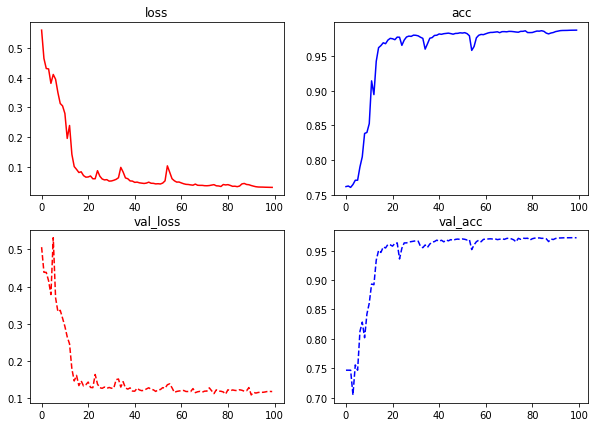

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))

ax[0, 0].set_title('loss')
ax[0, 0].plot(history.history['loss'], 'r')
ax[0, 1].set_title('acc')
ax[0, 1].plot(history.history['acc'], 'b')

ax[1, 0].set_title('val_loss')
ax[1, 0].plot(history.history['val_loss'], 'r--')
ax[1, 1].set_title('val_acc')
ax[1, 1].plot(history.history['val_acc'], 'b--')

plt.show()

1/1 [==============================] - 2s 2s/step


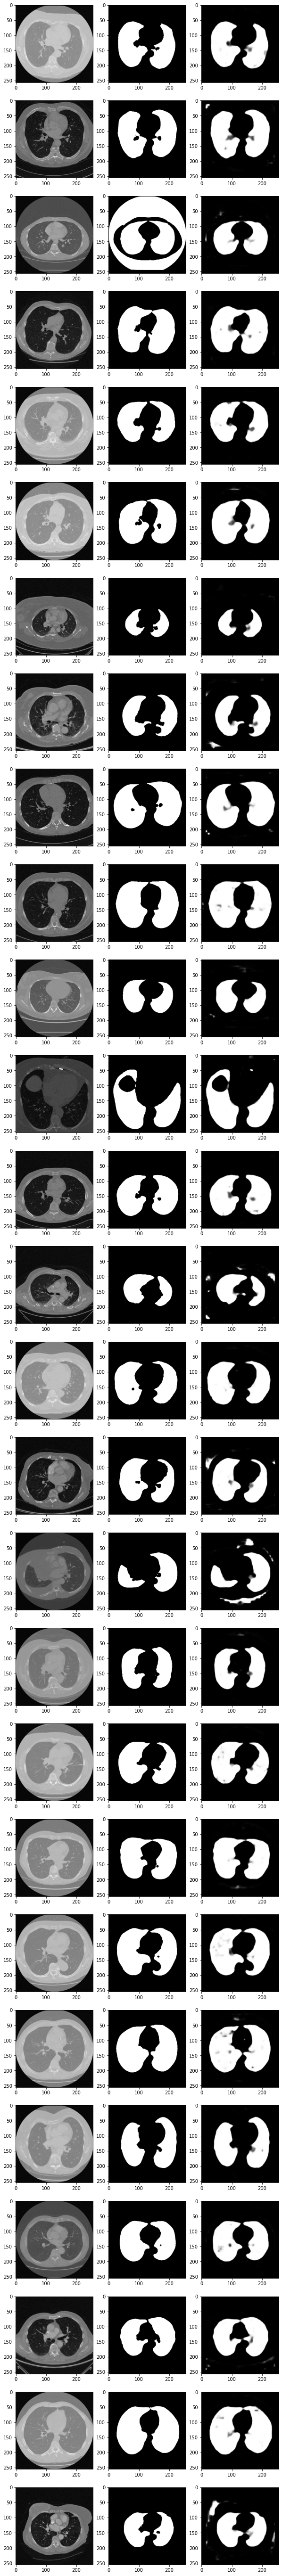

In [ ]:
preds = model.predict(X_val)

fig, ax = plt.subplots(len(X_val), 3, figsize=(10, 100))

for i, pred in enumerate(preds):
    ax[i, 0].imshow(X_val[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(y_val[i].squeeze(), cmap='gray')
    ax[i, 2].imshow(pred.squeeze(), cmap='gray')